In [1]:
abstract type AbstractLayer end

In [2]:
mutable struct MulLayer{T<:AbstractFloat} <: AbstractLayer
    x::T
    y::T
    (::Type{MulLayer{T}})() where {T<:AbstractFloat} = new{T}()
end

In [3]:
function forward(self::MulLayer{T}, x::T, y::T) where {T<:AbstractFloat}
    self.x = x
    self.y = y
    out = x * y
    return out
end
@inline forward(lyr::MulLayer{T}, x, y) where T = forward(lyr, T(x), T(y))

forward (generic function with 2 methods)

In [4]:
function backward(self::MulLayer{T}, dout::T) where {T<:AbstractFloat}
    dx = dout * self.y
    dy = dout * self.x
    return dx, dy
end
@inline backward(lyr::MulLayer{T}, dout) where T = backward(lyr, T(dout))

backward (generic function with 2 methods)

In [5]:
apple = 100
apple_num = 2
tax = 1.1

1.1

In [6]:
mul_apple_layer = MulLayer{Float32}()
mul_tax_layer = MulLayer{Float32}()

MulLayer{Float32}(-4.3302503f-36, 4.5708f-41)

In [7]:
apple_price = forward(mul_apple_layer, apple, apple_num)
price = forward(mul_tax_layer, apple_price, tax)

220.0f0

In [8]:
dprice = 1
dapple_price, dtax = backward(mul_tax_layer, dprice)
dapple, dapple_num = backward(mul_apple_layer, dapple_price)
(dapple, dapple_num, dtax)

(2.2f0, 110.0f0, 200.0f0)

In [9]:
mutable struct AddLayer{T<:AbstractFloat} <: AbstractLayer end

function forward(self::AddLayer{T}, x::T, y::T) where {T<:AbstractFloat}
    out = x + y
    return out
end
@inline forward(lyr::AddLayer{T}, x, y) where T = forward(lyr, T(x), T(y))
    
function backward(self::AddLayer{T}, dout::T) where {T<:AbstractFloat}
    dx = dout * 1
    dy = dout * 1
    return dx, dy
end
@inline backward(lyr::AddLayer{T}, dout) where T = backward(lyr, T(dout))

backward (generic function with 4 methods)

In [10]:
apple = 100
apple_num = 2
orange = 150
orange_num = 3
tax = 1.1

1.1

In [11]:
mul_apple_layer = MulLayer{Float32}()
mul_orange_layer = MulLayer{Float32}()
add_apple_orange_layer = AddLayer{Float32}()
mul_tax_layer = MulLayer{Float32}()

MulLayer{Float32}(3.0567f-41, 0.0f0)

In [12]:
apple_price = forward(mul_apple_layer, apple, apple_num)
orange_price = forward(mul_orange_layer, orange, orange_num)
all_price = forward(add_apple_orange_layer, apple_price, orange_price)
price = forward(mul_tax_layer, all_price, tax)

715.0f0

In [13]:
dprice = 1
dall_price, dtax = backward(mul_tax_layer, dprice)
dapple_price, dorange_price = backward(add_apple_orange_layer, dall_price)
dorange, dorange_num = backward(mul_orange_layer, dorange_price)
dapple, dapple_num = backward(mul_apple_layer, dapple_price)
(dapple, dapple_num, dorange, dorange_num, dtax)

(2.2f0, 110.0f0, 3.3000002f0, 165.0f0, 650.0f0)

## Relu

In [14]:
mutable struct ReluLayer{T<:AbstractFloat} <: AbstractLayer
    mask::AbstractArray{Bool}
    (::Type{ReluLayer{T}})() where {T} = new{T}()
end

In [15]:
function forward(self::ReluLayer{T}, x::AbstractArray{T}) where {T<:AbstractFloat}
    mask = self.mask = (x .<= 0)
    out = copy(x)
    out[mask] .= zero(T)
    out
end

forward (generic function with 5 methods)

In [16]:
function backward(self::ReluLayer{T}, dout::AbstractArray{T}) where {T<:AbstractFloat}
    dout[self.mask] .= zero(T)
    dout
end

backward (generic function with 5 methods)

In [17]:
relulyr = ReluLayer{Float32}()
forward(relulyr, Float32[1.0 -0.5; -2.0 3.0])

2×2 Array{Float32,2}:
 1.0  0.0
 0.0  3.0

In [18]:
relulyr.mask

2×2 Array{Bool,2}:
 false   true
  true  false

In [19]:
backward(relulyr, Float32[1.0 1.0; 1.0 1.0])

2×2 Array{Float32,2}:
 1.0  0.0
 0.0  1.0

## Sigmoid

In [20]:
sigmoid(x::T) where {T<:AbstractFloat} = inv(one(T) + exp(-x))

sigmoid (generic function with 1 method)

In [21]:
mutable struct SigmoidLayer{T<:AbstractFloat} <: AbstractLayer
    out::AbstractArray{T}
    (::Type{SigmoidLayer{T}})() where {T} = new{T}()
end

In [22]:
function forward(self::SigmoidLayer{T}, x::A) where {T<:AbstractFloat, A<:AbstractArray{T}}
    self.out = sigmoid.(x)
end

forward (generic function with 6 methods)

In [23]:
function backward(self::SigmoidLayer{T}, dout::A) where {T<:AbstractFloat, A<:AbstractArray{T}}
    dout .* (one(T) .- self.out) .* self.out
end

backward (generic function with 6 methods)

In [24]:
sigmoidlyr = SigmoidLayer{Float32}()
forward(sigmoidlyr, Float32[-5:5;])

11-element Array{Float32,1}:
 0.00669285
 0.0179862 
 0.0474259 
 0.119203  
 0.268941  
 0.5       
 0.731059  
 0.880797  
 0.952574  
 0.982014  
 0.993307  

In [25]:
backward(sigmoidlyr, ones(Float32,11))

11-element Array{Float32,1}:
 0.00664806
 0.0176627 
 0.0451767 
 0.104994  
 0.196612  
 0.25      
 0.196612  
 0.104994  
 0.0451767 
 0.0176627 
 0.00664803

## Swish

https://arxiv.org/pdf/1710.05941.pdf

${\rm swish}(x) = x \cdot {\rm sigmod}(x)$

In [26]:
mutable struct SwishLayer{T<:AbstractFloat} <: AbstractLayer
    out::AbstractArray{T}
    ς::AbstractArray{T} # ← sigmoid
    (::Type{SwishLayer{T}})() where {T} = new{T}()
end

In [27]:
function forward(self::SwishLayer{T}, x::A) where {T<:AbstractFloat, A<:AbstractArray{T}}
    ς = self.ς = sigmoid.(x)
    self.out = x .* ς
end

forward (generic function with 7 methods)

In [28]:
function backward(self::SwishLayer{T}, dout::A) where {T<:AbstractFloat, A<:AbstractArray{T}}
    dout .* (self.out .+ self.ς .* (one(T) .- self.out))
end

backward (generic function with 7 methods)

In [29]:
swishlyr = SwishLayer{Float32}()
forward(swishlyr, Float32[-5:5;])

11-element Array{Float32,1}:
 -0.0334643
 -0.0719448
 -0.142278 
 -0.238406 
 -0.268941 
  0.0      
  0.731059 
  1.76159  
  2.85772  
  3.92806  
  4.96654  

In [30]:
backward(swishlyr, ones(Float32,11))

11-element Array{Float32,1}:
 -0.0265474
 -0.0526646
 -0.0881041
 -0.0907843
  0.0723295
  0.5      
  0.927671 
  1.09078  
  1.0881   
  1.05266  
  1.02655  

### 5.6.2 バッチ版 Affine レイヤ

In [31]:
mutable struct AffineLayer{T<:AbstractFloat} <: AbstractLayer
    W::AbstractMatrix{T}
    b::AbstractVector{T}
    x::AbstractArray{T}
    dW::AbstractMatrix{T}
    db::AbstractVector{T}
    function (::Type{AffineLayer})(W::AbstractMatrix{T}, b::AbstractVector{T}) where {T}
        lyr = new{T}()
        lyr.W = W
        lyr.b = b
        lyr
    end
end

In [32]:
function forward(self::AffineLayer{T}, x::A) where {T<:AbstractFloat, A<:AbstractArray{T}}
    self.x = x
    self.W * x .+ self.b
end

forward (generic function with 8 methods)

In [33]:
function backward(self::AffineLayer{T}, dout::A) where {T<:AbstractFloat, A<:AbstractArray{T}}
    dx = self.W' * dout
    self.dW = dout * self.x'
    self.db = _sumvec(dout)
    dx
end
@inline _sumvec{T}(dout::AbstractVector{T}) = dout
@inline _sumvec{T}(dout::AbstractMatrix{T}) = vec(mapslices(sum, dout, 2))
@inline _sumvec{T,N}(dout::AbstractArray{T,N}) = vec(mapslices(sum, dout, 2:N))

_sumvec (generic function with 3 methods)

### 5.6.3 Softmax-with-Loss レイヤ

In [34]:
function softmax(a::AbstractVector{T}) where {T<:AbstractFloat}
    c = maximum(a)  # オーバーフロー対策
    exp_a = exp.(a .- c)
    exp_a ./ sum(exp_a)
end

function softmax(a::AbstractMatrix{T}) where {T<:AbstractFloat}
    mapslices(softmax, a, 1)
end

softmax (generic function with 2 methods)

In [35]:
function crossentropyerror(y::Vector, t::Vector)
    δ = 1e-7  # アンダーフロー対策
    # -sum(t .* log.(y .+ δ))
    -(t ⋅ log.(y .+ δ))
end
function crossentropyerror(y::Matrix, t::Matrix)
    batch_size = size(y, 2)
    δ = 1e-7  # アンダーフロー対策
    # -sum(t .* log(y .+ δ)) / batch_size
    -vecdot(t, log.(y .+ δ)) / batch_size
end
function crossentropyerror(y::Matrix, t::Vector)
    batch_size = size(y, 2)
    δ = 1e-7  # アンダーフロー対策
    -sum([log.(y[t[i]+1, i]) for i=1:batch_size] .+ δ) / batch_size
end

crossentropyerror (generic function with 3 methods)

In [36]:
mutable struct SoftmaxWithLossLayer{T<:AbstractFloat} <: AbstractLayer
    loss::T
    y::AbstractArray{T}
    t::AbstractArray{T}
    (::Type{SoftmaxWithLossLayer{T}})() where {T} = new{T}()
end

In [37]:
function forward(self::SoftmaxWithLossLayer{T}, x::AbstractArray{T}, t::AbstractArray{T}) where {T<:AbstractFloat}
    self.t = t
    y = self.y = softmax(x)
    self.loss = crossentropyerror(y, t)
end

forward (generic function with 9 methods)

In [38]:
function backward(lyr::SoftmaxWithLossLayer{T}, dout::T=one(T)) where {T<:AbstractFloat}
    dout .* _swlvec(lyr.y, lyr.t)
end
@inline _swlvec(y::AbstractArray{T}, t::AbstractVector{T}) where {T<:AbstractFloat} = y .- t
@inline _swlvec(y::AbstractArray{T}, t::AbstractMatrix{T}) where {T<:AbstractFloat} = (y .- t) / size(t)[2]

_swlvec (generic function with 2 methods)

### 5.7.2 誤差逆伝播法に対応したニューラルネットワークの実装

In [39]:
mutable struct TwoLayerNet{T<:AbstractFloat}
    a1lyr::AffineLayer{T}
    swish1lyr::SwishLayer
    a2lyr::AffineLayer{T}
    softmaxlyr::SoftmaxWithLossLayer{T}
end

function (::Type{TwoLayerNet{T}})(input_size::Int, hidden_size::Int, output_size::Int,
        weight_init_std::T=T(0.01)) where {T<:AbstractFloat}
    W1 = weight_init_std .* randn(T, hidden_size, input_size)
    b1 = zeros(T, hidden_size)
    W2 = weight_init_std .* randn(T, output_size, hidden_size)
    b2 = zeros(T, output_size)
    a1lyr = AffineLayer(W1, b1)
    swish1lyr = SwishLayer{T}()
    a2lyr = AffineLayer(W2, b2)
    softmaxlyr = SoftmaxWithLossLayer{T}()
    TwoLayerNet(a1lyr, swish1lyr, a2lyr, softmaxlyr)
end

In [40]:
function predict(net::TwoLayerNet{T}, x::AbstractArray{T}) where {T<:AbstractFloat}
    a1 = forward(net.a1lyr, x)
    z1 = forward(net.swish1lyr, a1)
    a2 = forward(net.a2lyr, z1)
    # softmax(a2)
    a2
end

predict (generic function with 1 method)

In [41]:
function loss(net::TwoLayerNet{T}, x::AbstractArray{T}, t::AbstractArray{T}) where {T<:AbstractFloat}
    y = predict(net, x)
    forward(net.softmaxlyr, y, t)
end

loss (generic function with 1 method)

In [42]:
function accuracy(net::TwoLayerNet{T}, x::AbstractArray{T}, t::AbstractArray{T}) where {T<:AbstractFloat}
    y = vec(mapslices(indmax, predict(net, x), 1))
    if ndims(t) > 1 t = vec(mapslices(indmax, t, 1)) end
    mean(y .== t)
end

accuracy (generic function with 1 method)

In [43]:
struct TwoLayerNetGrads{T}
    W1::AbstractMatrix{T}
    b1::AbstractVector{T}
    W2::AbstractMatrix{T}
    b2::AbstractVector{T}
end

In [44]:
function Base.gradient(net::TwoLayerNet{T}, x::AbstractArray{T}, t::AbstractArray{T}) where {T<:AbstractFloat}
    # forward
    loss(net, x, t)
    # backward
    dout = one(T)
    dz2 = backward(net.softmaxlyr, dout)
    da2 = backward(net.a2lyr, dz2)
    dz1 = backward(net.swish1lyr, da2)
    da1 = backward(net.a1lyr, dz1)
    TwoLayerNetGrads(net.a1lyr.dW, net.a1lyr.db, net.a2lyr.dW, net.a2lyr.db)
end

In [45]:
function applygradient!(net::TwoLayerNet{T}, grads::TwoLayerNetGrads{T}, learning_rate::T) where {T<:AbstractFloat}
    net.a1lyr.W -= learning_rate .* grads.W1
    net.a1lyr.b -= learning_rate .* grads.b1
    net.a2lyr.W -= learning_rate .* grads.W2
    net.a2lyr.b -= learning_rate .* grads.b2
end

applygradient! (generic function with 1 method)

### 5.7.3 誤差逆伝播法の勾配確認

In [46]:
include("dataset/load_mnist.jl")

LoadMnist

In [47]:
(x_train, t_train), (x_test, t_test) = LoadMnist.load_mnist(;
        normalize=true, flatten=true, one_hot_label=true)

((Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], UInt8[0x00 0x01 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 0x00 … 0x00 0x01; 0x00 0x00 … 0x00 0x00]), (Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], UInt8[0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00; … ; 0x00 0x00 … 0x00 0x00; 0x00 0x00 … 0x00 0x00]))

In [48]:
size(t_train)

(10, 60000)

In [49]:
network = TwoLayerNet{Float32}(784, 50, 10)

TwoLayerNet{Float32}(AffineLayer{Float32}(Float32[-0.00437213 -0.00535684 … 0.0208077 -0.0142625; 0.0066374 0.00116072 … 0.000623654 0.00130582; … ; 0.0053605 -0.00484072 … -0.0072852 0.000980641; -0.0023288 -0.00294006 … -0.0161009 0.0108982], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], #undef, #undef, #undef), SwishLayer{Float32}(#undef, #undef), AffineLayer{Float32}(Float32[0.0108438 0.0110532 … -0.0168137 -0.00225051; 0.00364182 0.0196788 … 0.0022597 -0.0160295; … ; 0.0102572 0.00416515 … 0.0103969 0.0134615; -0.00396176 -0.00276896 … 0.0133701 0.00257647], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], #undef, #undef, #undef), SoftmaxWithLossLayer{Float32}(-6.253567f-37, #undef, #undef))

In [50]:
x_batch = x_train[:, 1:3]

784×3 Array{Float32,2}:
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 ⋮            
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [51]:
t_batch = Matrix{Float32}(t_train[:, 1:3])

10×3 Array{Float32,2}:
 0.0  1.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  1.0
 1.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0
 0.0  0.0  0.0

In [52]:
predict(network, x_batch)

10×3 Array{Float32,2}:
  0.000521476  -0.00248234   0.00016534 
 -0.00190483   -0.00597896   0.00323541 
 -0.00162247   -0.00112089  -0.000387626
 -0.00216153   -0.00177305   0.000655555
 -0.00343322   -0.00300419  -0.00181358 
  0.00148688    0.00311847   0.00269657 
  0.00205574    0.00127515   0.00359407 
  0.00110265    0.00170419   0.00130954 
 -0.00231802   -0.00197851   0.00196059 
  0.00392204    0.00966551   0.00218072 

In [53]:
loss(network, x_batch, t_batch)
# loss(network, x_batch, Matrix{Float32}(t_batch))

2.3038802571596513

In [54]:
grad_backprop = gradient(network, x_batch, t_batch)

TwoLayerNetGrads{Float32}(Float32[0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], Float32[0.000190139, 0.00185699, -0.000658485, -0.00103952, 0.000873459, -0.00342022, 0.00166121, 0.00290097, 0.00127283, -0.00271686  …  0.00121033, 0.00284127, -0.0029006, 0.00101315, 0.00199662, 0.00325893, 0.000399526, -3.60861f-5, 0.00245165, 0.00178564], Float32[0.0037145 -0.000163236 … 0.00154954 -0.00375592; -0.00197214 0.00335333 … -0.00187564 0.00105822; … ; -0.00197374 0.00335169 … -0.00187489 0.00105998; -0.00198856 0.00336196 … -0.00187813 0.00106985], Float32[-0.233429, 0.0998098, 0.0998598, 0.0998548, -0.233644, -0.233126, 0.100195, 0.100101, 0.0998863, 0.100492])

### 5.7.4 誤差逆伝播法を使った学習

In [55]:
network = TwoLayerNet{Float32}(784, 50, 10)

TwoLayerNet{Float32}(AffineLayer{Float32}(Float32[0.0105115 -0.000759424 … -0.00163311 -0.00281529; -0.0048874 -0.00136029 … -0.00554172 0.012044; … ; 0.0100392 -0.0111736 … 0.00941741 -0.00328035; 0.00679795 -0.00488278 … 0.0142397 0.00110842], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], #undef, #undef, #undef), SwishLayer{Float32}(#undef, #undef), AffineLayer{Float32}(Float32[0.00740376 0.0297674 … -0.00311229 0.00305034; -0.00724641 -0.00686658 … 0.0167087 -0.0106198; … ; -3.8f-5 0.00181323 … 0.00159703 0.01104; 0.0110531 0.00103081 … 0.00578464 -0.000473667], Float32[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], #undef, #undef, #undef), SoftmaxWithLossLayer{Float32}(-4.7411833f-37, #undef, #undef))

In [56]:
iters_num = 10000;
train_size = size(x_train, 2); # => 60000
batch_size = 100;
learning_rate = Float32(0.1);

In [57]:
train_loss_list = Float32[];
train_acc_list = Float32[];
test_acc_list = Float32[];

In [58]:
iter_per_epoch = max(train_size ÷ batch_size, 1)

600

In [59]:
for i = 1:iters_num
    batch_mask = rand(1:train_size, batch_size)
    x_batch = x_train[:, batch_mask]
    t_batch = Matrix{Float32}(t_train[:, batch_mask])
    
    # 誤差逆伝播法によって勾配を求める
    grads = gradient(network, x_batch, t_batch)
    
    # 更新
    applygradient!(network, grads, learning_rate)
    
    _loss = loss(network, x_batch, t_batch)
    push!(train_loss_list, _loss)

    if i % iter_per_epoch == 1
        train_acc = accuracy(network, x_train, Matrix{Float32}(t_train))
        test_acc = accuracy(network, x_test, Matrix{Float32}(t_test))
        push!(train_acc_list, train_acc)
        push!(test_acc_list, test_acc)
        println("$(i-1): train_acc=$(train_acc) / test_acc=$(test_acc)")
    end
end

0: train_acc=0.047516666666666665 / test_acc=0.0425
600: train_acc=0.8980166666666667 / test_acc=0.9017
1200: train_acc=0.9150666666666667 / test_acc=0.9171
1800: train_acc=0.9266166666666666 / test_acc=0.9274
2400: train_acc=0.938 / test_acc=0.9351
3000: train_acc=0.9419 / test_acc=0.94
3600: train_acc=0.9514666666666667 / test_acc=0.9496
4200: train_acc=0.9568 / test_acc=0.9532
4800: train_acc=0.9595666666666667 / test_acc=0.9567
5400: train_acc=0.9634833333333334 / test_acc=0.9596
6000: train_acc=0.9673833333333334 / test_acc=0.9644
6600: train_acc=0.9694 / test_acc=0.9642
7200: train_acc=0.9717833333333333 / test_acc=0.9667
7800: train_acc=0.9724333333333334 / test_acc=0.9668
8400: train_acc=0.9739666666666666 / test_acc=0.9693
9000: train_acc=0.97565 / test_acc=0.9689
9600: train_acc=0.9769333333333333 / test_acc=0.9705


In [60]:
final_train_acc = accuracy(network, x_train, Matrix{Float32}(t_train))
final_test_acc = accuracy(network, x_test, Matrix{Float32}(t_test))
push!(train_acc_list, final_train_acc)
push!(test_acc_list, final_test_acc)
println("final: train_acc=$(final_train_acc) / test_acc=$(final_test_acc)")

final: train_acc=0.9774333333333334 / test_acc=0.9694


In [61]:
using PyPlot
const plt = PyPlot

PyPlot

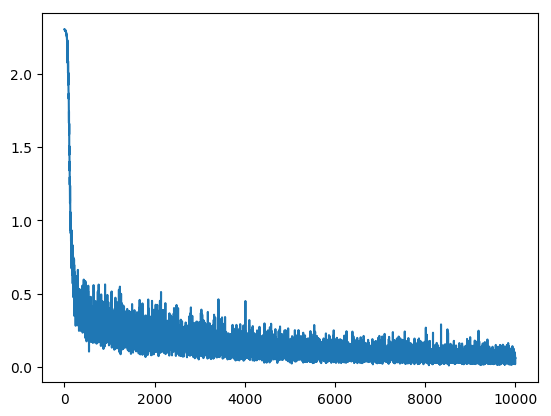

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7f6a5dcaa048>

In [62]:
plt.plot(1:length(train_loss_list), train_loss_list)

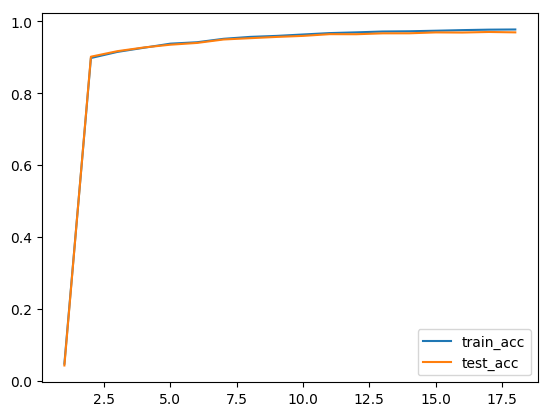

PyObject <matplotlib.legend.Legend object at 0x7f6a5ddf1fd0>

In [63]:
x1 = [1:length(train_acc_list);]
plt.plot(x1, train_acc_list, label="train_acc")
plt.plot(x1, test_acc_list, label="test_acc")
plt.legend()